In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import random
from IPython.display import clear_output

In [2]:
#define hyper-parameters
ALPHA = 0.1
GAMMA = 0.95
N_STATE = 20
ACTIONS = [0,1]#0代表向左，1代表向右
MAX_EPISODES = 300
MAX_TIMESTEP = 50

epsilon_start = 1.0
epsilon_final = 0.01
#降低减少时的速率
epsilon_decay = 50

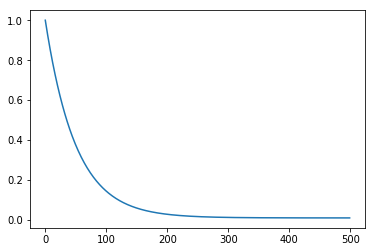

In [3]:
epsilon_by_frame = lambda frame_idx:epsilon_final + (epsilon_start - epsilon_final)*math.exp(-frame_idx/epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(500)])

In [4]:
def plot_reward(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('frame %s. mean_reward: %s'%(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.xlabel('epoch')
    plt.ylabel('reward')
    plt.show()

In [5]:
class QL_environment():
    """
    环境形状(以state=20,action=2为例)：
    x [-]*18 o
    位置0为陷阱，位置o为奖励值为1的位置其余位置每动一次奖励值-0.5
    """
    def __init__(self):
        self.state = np.random.choice(10)
        self.timestep = 0
    
    def reset(self):
        self.state = np.random.choice(10)
        return np.array(self.state)
    
    def step(self, action):
        if action == 1 :
            if self.state == N_STATE-1:
                reward = 1
            else:
                reward = -0.5
            next_state = self.state + 1
        else:
            if self.state == 0:
                next_state = 0
            else:
                next_state = self.state - 1
            reward = -0.5
        done = bool(self.state == (N_STATE-1))if (self.timestep < MAX_TIMESTEP) else True
        if not done:
            self.timestep += 1
            self.state = next_state 
        else:
            self.timestep = 0
        return self.state, reward, done

In [6]:
class Q_learning():
    def __init__(self, n_state, actions):
        self.qtable = pd.DataFrame(
            data = np.zeros((n_state, len(actions))),
            index = np.arange(n_state),
            columns = actions,
            )
        
    def choose_action(self, state, epsilon):
        #epsilion - greedy policy
        '''
        np.random.choice(a,size=None,replace=True,p=None)
            a:一维数组(表示在其中选一个)或者int数(表示在[0,i-1]中选一个)
            p:对a中的每个数设置权重，即被选中的概率
        '''
        if random.random() > epsilon:
            action = self.qtable.loc[state,:].idxmax()
        else:
            action = np.random.choice(ACTIONS)
        return action
    
    def update_Q_table(self, state, action, reward, next_state):
        current_Q = self.qtable.iloc[state,action]
        next_Q = self.qtable.iloc[next_state,:].max()
        DELTA = reward + GAMMA*next_Q - current_Q
        current_Q += ALPHA*DELTA
        self.qtable.iloc[state,action] = current_Q

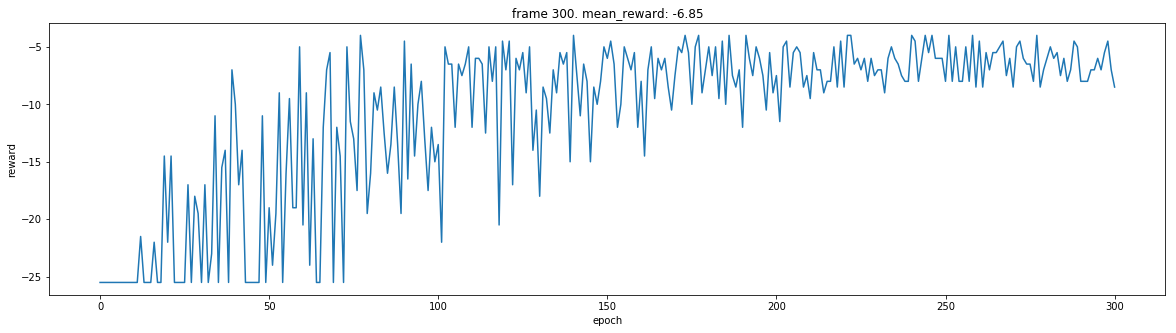

           0          1
0  -5.531485  -5.505859
1  -5.405919  -5.057098
2  -5.215117  -4.306431
3  -5.026214  -3.120056
4  -4.816274  -2.166868
5  -4.578955  -1.206903
6  -4.397062  -0.239668
7  -3.906822   0.692249
8  -3.553932   1.567057
9  -3.422475   2.459404
10 -3.299557   3.395716
11 -2.473266   4.382494
12 -2.180366   5.423420
13 -2.340431   6.523720
14 -0.735434   7.687714
15  0.411478   8.910918
16  0.535379  10.187727
17 -0.270819  11.537768
18  2.156448  12.957094
19  2.112385  14.457079


In [7]:
all_rewards = []
q_learning = Q_learning(N_STATE,ACTIONS)
ql_environment = QL_environment()
for episode in range(1+MAX_EPISODES):
    episode_rewards = 0
    done = False
    ql_environment.reset()
    epsilon = epsilon_by_frame(episode)
    while not done:
        state = ql_environment.state
        action = q_learning.choose_action(state, epsilon)
        next_state, reward, done = ql_environment.step(action)
        episode_rewards += reward
        q_learning.update_Q_table(state,action,reward,next_state)
    all_rewards.append(episode_rewards)
    plot_reward(episode,all_rewards)
print(q_learning.qtable)

In [8]:
# Q_learning:主要是 Q = Q + α(R + λ(Q') - Q ) 公式的实现
# class QL_environment():
#     def __init__(self):
#     def reset(self):
#     def step(self, action):
# class Q_learning():
#     def __init__(self, n_state, actions):
#     def choose_action(self, state, epsilon):
#     def update_Q_table(self, state, action, reward, next_state):
# tips:
#     lambda:
#     快速构建函数，当然我只用到了最基础的操作
#     其他操作：
#     1.多返回值：lambda a, b :(a+1, b+1)返回为一个元组(相当于单返回值)
#     2.和map连用快速定义并返回：
#         L = [1,2,3,4]
#         list(map(lambda x: x**2, L))
#         Out[1]: [1, 4, 9, 16]
#     3.进行数据的挑选
#         L = [1,2,3,4]
#         list(filter(lambda x : x % 2 == 0, L))
#         Out[2]: [2, 4]
#     plot:
#     画图时使用了from IPython.display import clear_output
#     可以实时画图，虽然有点慢，但挺直观的可以实时更新